Task 1: Full feature model (all 141 features)

 Regression approach
Binary classification (score <3 vs ≥3)


Task 2: Reduced feature model (≤10 features)

Same evaluation as Task 1
Feature selection is critical

In [ ]:
#Data Exploration and Preprocessing
#1.1 Initial Data Analysis


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('CSI_7_MAL_2526_Data.xlsx')

# Basic info
print(f"Total rows: {len(df)}")
print(f"Unique PatIDs: {df['PatID'].nunique()}")  # Should be 319
print(f"Columns: {len(df.columns)}")  # Should be 143 (PatID + SeverityScore + 141 features)

# Check visits per patient
visits_per_patient = df.groupby('PatID').size()
print(f"Mean visits per patient: {visits_per_patient.mean():.2f}")
print(f"Patients with 3 visits: {(visits_per_patient == 3).sum()}")
print(f"Patients with <3 visits: {(visits_per_patient < 3).sum()}")

Total rows: 318
Unique PatIDs: 106
Columns: 143
Mean visits per patient: 3.00
Patients with 3 visits: 106
Patients with <3 visits: 0


1.2  Severity Score
Distribution Analysis

Total valid assessments: 306

Severity Score Distribution:
Severity Score
0.0    81
1.0     6
2.0    30
3.0    68
4.0    22
5.0    99
Name: count, dtype: int64

Percentages:
Severity Score
0.0    26.470588
1.0     1.960784
2.0     9.803922
3.0    22.222222
4.0     7.189542
5.0    32.352941
Name: count, dtype: float64

Binary Classification:
No inflammation (<3): 117 (38.2%)
Inflammation (≥3): 189 (61.8%)


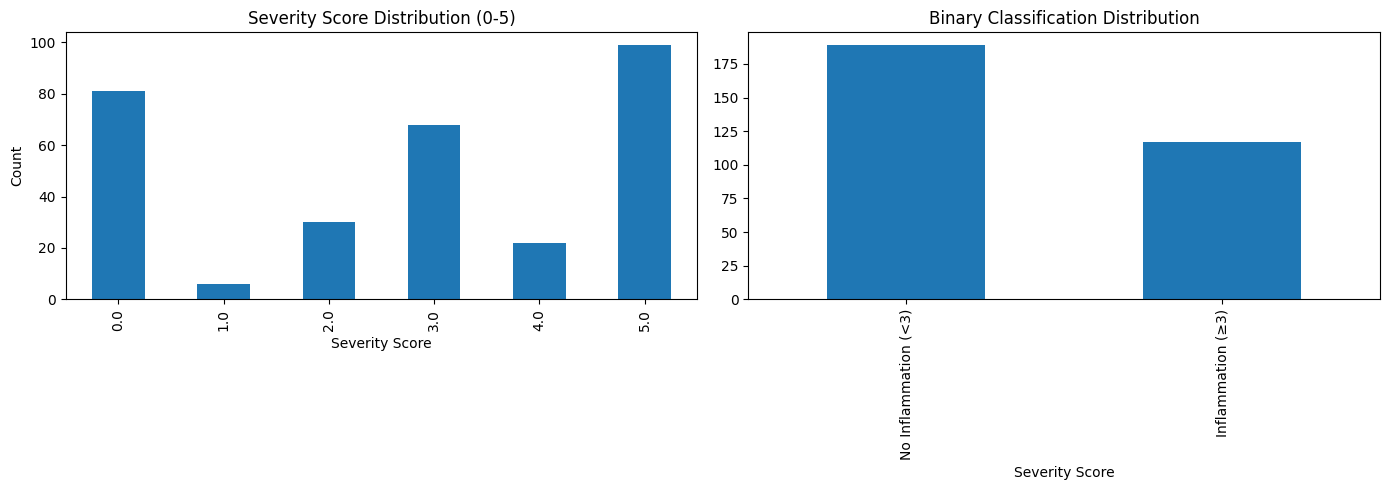

In [ ]:
# Remove empty rows (missing assessments)
df_clean = df.dropna(subset=['Severity Score'])

print(f"Total valid assessments: {len(df_clean)}")

# Severity score distribution
severity_counts = df_clean['Severity Score'].value_counts().sort_index()
print("\nSeverity Score Distribution:")
print(severity_counts)
print(f"\nPercentages:")
print(severity_counts / len(df_clean) * 100)

# Binary distribution
binary = (df_clean['Severity Score'] >= 3).astype(int)
print(f"\nBinary Classification:")
print(f"No inflammation (<3): {(binary==0).sum()} ({(binary==0).sum()/len(binary)*100:.1f}%)")
print(f"Inflammation (≥3): {(binary==1).sum()} ({(binary==1).sum()/len(binary)*100:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
severity_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Severity Score Distribution (0-5)')
axes[0].set_xlabel('Severity Score')
axes[0].set_ylabel('Count')

binary.value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Binary Classification Distribution')
axes[1].set_xticklabels(['No Inflammation (<3)', 'Inflammation (≥3)'])
plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300)

1.3 Missing Data Analysis

Features with >50% missing: 0
Features with >20% missing: 0
Features with >5% missing: 0


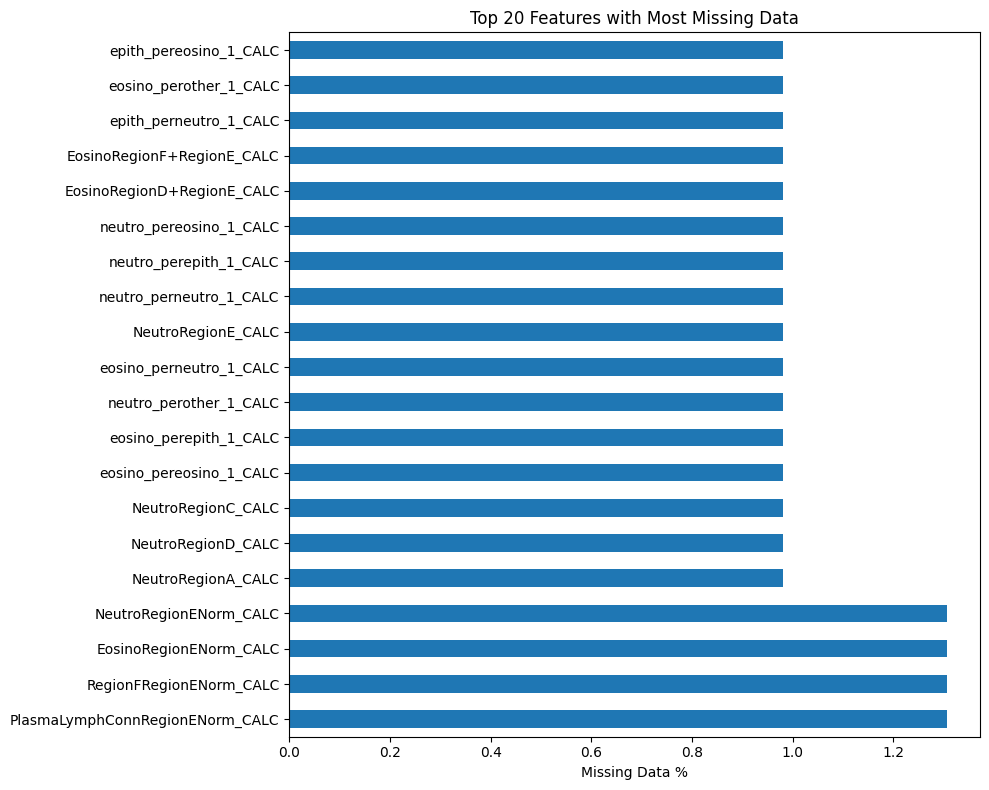

In [ ]:
# Missing data per feature
missing_per_feature = df_clean.isnull().sum()
missing_pct = (missing_per_feature / len(df_clean) * 100).sort_values(ascending=False)

print(f"Features with >50% missing: {(missing_pct > 50).sum()}")
print(f"Features with >20% missing: {(missing_pct > 20).sum()}")
print(f"Features with >5% missing: {(missing_pct > 5).sum()}")

# Visualize top 20 features with most missing data
if missing_pct.max() > 0:
    missing_pct.head(20).plot(kind='barh', figsize=(10, 8))
    plt.title('Top 20 Features with Most Missing Data')
    plt.xlabel('Missing Data %')
    plt.tight_layout()
    plt.savefig('missing_data_analysis.png', dpi=300)

1.4 Feature Understanding and Correlation Analysis


In [ ]:
# Prepare features and target
feature_cols = [col for col in df_clean.columns if col not in ['PatID', 'Severity Score']]
X = df_clean[feature_cols].fillna(0)  # Fill any remaining NaN with 0
y = df_clean['Severity Score'].values
groups = df_clean['PatID'].values

print(f"Number of features: {len(feature_cols)}")
print(f"Number of samples: {len(X)}")


Number of features: 141
Number of samples: 306



Top 20 Features Correlated with Severity Score:
other_pereosino_1_CALC           0.658035
other_pereosino_2_CALC           0.635932
other_perneutro_2_CALC           0.630170
other_perneutro_1_CALC           0.617428
RegionFTotalNorm_CALC            0.611463
other_perother_2_CALC            0.569282
neutro_perepith_1_std_CALC       0.567630
neutro_pereosino_1_CALC          0.565892
other_perepith_2_CALC            0.563967
neutro_pereosino_2_CALC          0.559024
other_perother_1_CALC            0.556288
epith_pereosino_1_CALC           0.549648
neutro_perepith_1_CALC           0.549303
neutro_perepith_2_CALC           0.548261
PlasmaLymphConnTotalNorm_CALC    0.539625
epith_perother_1_CALC            0.534267
neutro_perepith_2_std_CALC       0.530037
NeutroRegionCNorm_CALC           0.528658
NeutroTotalNorm_CALC             0.518937
NeutroRegionANorm_CALC           0.518520
dtype: float64

Highly correlated feature pairs (>0.95): 90


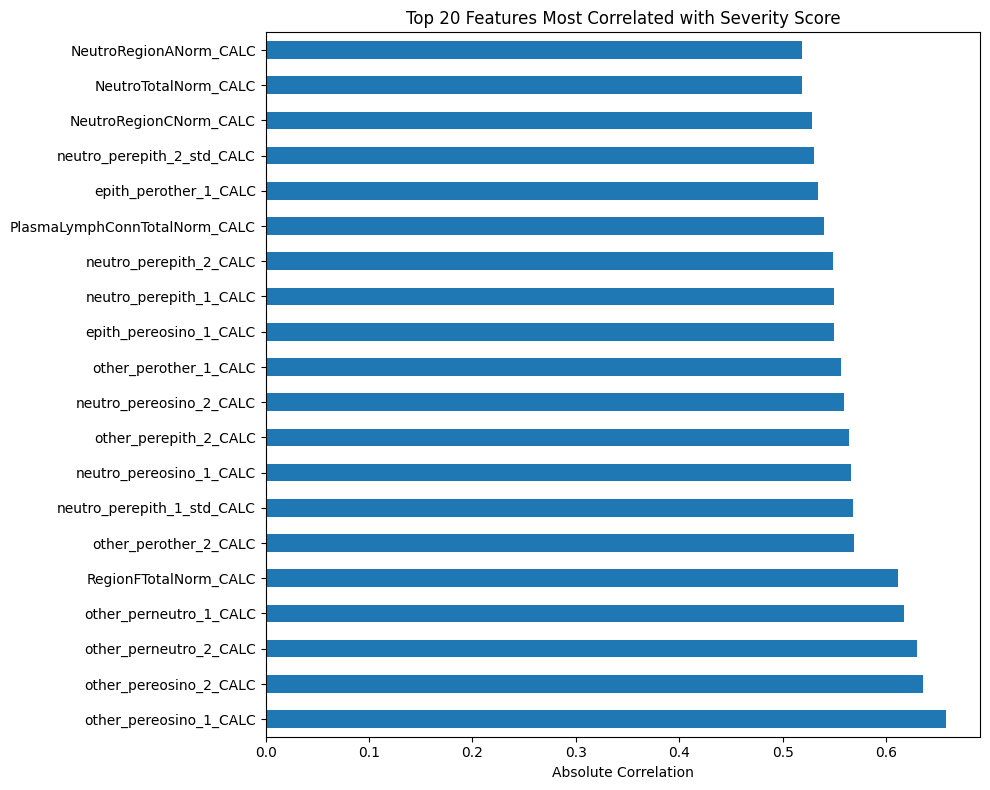

In [ ]:
# Separate features from target
feature_cols = [col for col in df_clean.columns if col not in ['PatID', 'Severity Score']]
X = df_clean[feature_cols]
y = df_clean['Severity Score']

# Correlation with target
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print("\nTop 20 Features Correlated with Severity Score:")
print(correlations.head(20))

# Save for later reference
correlations.to_csv('feature_correlations.csv')

# Visualize top 20
correlations.head(20).plot(kind='barh', figsize=(10, 8))
plt.title('Top 20 Features Most Correlated with Severity Score')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.savefig('top_correlations.png', dpi=300)

# High correlation between features (multicollinearity)
feature_corr_matrix = X.corr().abs()
high_corr_pairs = []
for i in range(len(feature_corr_matrix.columns)):
    for j in range(i+1, len(feature_corr_matrix.columns)):
        if feature_corr_matrix.iloc[i, j] > 0.95:
            high_corr_pairs.append((
                feature_corr_matrix.columns[i],
                feature_corr_matrix.columns[j],
                feature_corr_matrix.iloc[i, j]
            ))

print(f"\nHighly correlated feature pairs (>0.95): {len(high_corr_pairs)}")

1.5 Handle Missing Data Strategy

In [ ]:
from sklearn.impute import SimpleImputer

# Strategy depends on missing percentage:
# Option 1: Drop features with >50% missing
features_to_drop = missing_pct[missing_pct > 50].index.tolist()
print(f"Dropping {len(features_to_drop)} features with >50% missing data")

# Option 2: Impute remaining missing values
# Use median (robust to outliers)
imputer = SimpleImputer(strategy='median')

# Note: fit imputer only on training data during CV

Dropping 0 features with >50% missing data


2.Data Preprocessing Pipeline

2.1 Complete Preprocessing Pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def preprocess_data(df, drop_threshold=50):
    """
    Complete preprocessing pipeline

    Parameters:
    - df: input dataframe
    - drop_threshold: % missing above which to drop features
    """
    # 1. Remove rows without target
    df_clean = df.dropna(subset=['Severity Score']).copy()

    # 2. Separate features and target
    feature_cols = [col for col in df_clean.columns
                   if col not in ['PatID', 'Severity Score']]

    X = df_clean[feature_cols]
    y = df_clean['Severity Score']
    groups = df_clean['PatID']  # For GroupKFold

    # 3. Drop features with too much missing data
    missing_pct = (X.isnull().sum() / len(X) * 100)
    cols_to_keep = missing_pct[missing_pct <= drop_threshold].index
    X = X[cols_to_keep]

    print(f"Features after dropping >50% missing: {X.shape[1]}")

    # 4. Check for constant features (no variance)
    constant_features = X.columns[X.std() == 0]
    if len(constant_features) > 0:
        print(f"Removing {len(constant_features)} constant features")
        X = X.drop(columns=constant_features)

    return X, y, groups

# Apply preprocessing
X, y, groups = preprocess_data(df)

print(f"\nFinal dataset shape:")
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"Unique patients: {groups.nunique()}")
print(f"Severity score range: {y.min()} to {y.max()}")

Features after dropping >50% missing: 141

Final dataset shape:
Samples: 306
Features: 141
Unique patients: 106
Severity score range: 0.0 to 5.0


2.2 Subject - Based Cross-Validation Setup

In [ ]:
from sklearn.model_selection import GroupKFold

# This is CRITICAL for correct evaluation
n_splits = 5  # or 10 for more stable results

gkf = GroupKFold(n_splits=n_splits)

print(f"Cross-validation with {n_splits} folds")
print(f"Each fold ensures all visits from a patient stay together\n")

# Verify split
for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
    train_patients = groups.iloc[train_idx].nunique()
    test_patients = groups.iloc[test_idx].nunique()

    # Check no patient overlap
    overlap = set(groups.iloc[train_idx]) & set(groups.iloc[test_idx])

    print(f"Fold {fold+1}:")
    print(f"  Train: {len(train_idx)} samples, {train_patients} patients")
    print(f"  Test:  {len(test_idx)} samples, {test_patients} patients")
    print(f"  Patient overlap: {len(overlap)} (should be 0)")
    print()

Cross-validation with 5 folds
Each fold ensures all visits from a patient stay together

Fold 1:
  Train: 245 samples, 85 patients
  Test:  61 samples, 21 patients
  Patient overlap: 0 (should be 0)

Fold 2:
  Train: 245 samples, 85 patients
  Test:  61 samples, 21 patients
  Patient overlap: 0 (should be 0)

Fold 3:
  Train: 245 samples, 85 patients
  Test:  61 samples, 21 patients
  Patient overlap: 0 (should be 0)

Fold 4:
  Train: 245 samples, 85 patients
  Test:  61 samples, 21 patients
  Patient overlap: 0 (should be 0)

Fold 5:
  Train: 244 samples, 84 patients
  Test:  62 samples, 22 patients
  Patient overlap: 0 (should be 0)



2.3 Create Preprocessing Functions for CV

In [ ]:
def prepare_fold_data(X, y, train_idx, test_idx):
    """
    Prepare data for one CV fold with proper preprocessing
    """
    X_train = X.iloc[train_idx].copy()
    X_test = X.iloc[test_idx].copy()
    y_train = y.iloc[train_idx].copy()
    y_test = y.iloc[test_idx].copy()

    # 1. Impute missing values (fit on train only!)
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )

    # 2. Scale features (fit on train only!)
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imputed),
        columns=X_train_imputed.columns,
        index=X_train_imputed.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_imputed),
        columns=X_test_imputed.columns,
        index=X_test_imputed.index
    )

    return X_train_scaled, X_test_scaled, y_train, y_test

3.TASK 1 - Full Feature Model


3.2 TASK 1 Implementation

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import numpy as np

def train_and_evaluate_task1(X, y, groups, model, model_name):
    """
    Train and evaluate model using GroupKFold CV
    """
    gkf = GroupKFold(n_splits=5)

    # Store results for each fold
    mae_scores = []
    accuracy_scores = []

    # Binary classification metrics
    binary_acc = []
    binary_sensitivity = []
    binary_specificity = []
    binary_auc = []

    all_y_true = []
    all_y_pred = []
    all_y_prob = []  # For ROC

    fold_num = 1

    for train_idx, test_idx in gkf.split(X, y, groups):
        print(f"Processing fold {fold_num}/{5}...")

        # Prepare data for this fold
        X_train, X_test, y_train, y_test = prepare_fold_data(
            X, y, train_idx, test_idx
        )

        # Train model
        model.fit(X_train, y_train)

        # Predict (continuous values)
        y_pred_continuous = model.predict(X_test)

        # Clip predictions to valid range [0, 5]
        y_pred_continuous = np.clip(y_pred_continuous, 0, 5)

        # Round to nearest integer for classification
        y_pred_class = np.round(y_pred_continuous).astype(int)

        # Calculate MAE
        mae = mean_absolute_error(y_test, y_pred_continuous)
        mae_scores.append(mae)

        # Calculate classification accuracy
        acc = accuracy_score(y_test, y_pred_class)
        accuracy_scores.append(acc)

        # Binary classification (score < 3 vs >= 3)
        y_test_binary = (y_test >= 3).astype(int)
        y_pred_binary = (y_pred_continuous >= 3).astype(int)

        # Binary accuracy
        binary_acc.append(accuracy_score(y_test_binary, y_pred_binary))

        # Confusion matrix for sensitivity/specificity
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test_binary, y_pred_binary)

        # Handle cases where only one class present
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            sensitivity = 0 if cm.shape[0] == 1 and y_test_binary.iloc[0] == 0 else 1
            specificity = 0 if cm.shape[0] == 1 and y_test_binary.iloc[0] == 1 else 1

        binary_sensitivity.append(sensitivity)
        binary_specificity.append(specificity)

        # AUC (use continuous predictions as probability proxy)
        from sklearn.metrics import roc_auc_score
        # Normalize to [0, 1] for probability
        y_prob = y_pred_continuous / 5.0
        try:
            auc = roc_auc_score(y_test_binary, y_prob)
            binary_auc.append(auc)
        except:
            auc = 0
            binary_auc.append(0)

        # Store for overall ROC curve
        all_y_true.extend(y_test_binary)
        all_y_pred.extend(y_pred_binary)
        all_y_prob.extend(y_prob)

        fold_num += 1

    # Compile results
    results = {
        'model_name': model_name,
        'mae_mean': np.mean(mae_scores),
        'mae_std': np.std(mae_scores),
        'accuracy_mean': np.mean(accuracy_scores),
        'accuracy_std': np.std(accuracy_scores),
        'binary_accuracy_mean': np.mean(binary_acc),
        'binary_accuracy_std': np.std(binary_acc),
        'binary_sensitivity_mean': np.mean(binary_sensitivity),
        'binary_sensitivity_std': np.std(binary_sensitivity),
        'binary_specificity_mean': np.mean(binary_specificity),
        'binary_specificity_std': np.std(binary_specificity),
        'binary_auc_mean': np.mean(binary_auc),
        'binary_auc_std': np.std(binary_auc),
        'all_y_true': all_y_true,
        'all_y_prob': all_y_prob
    }

    return results

# Train multiple models
models = {
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    'LightGBM': LGBMRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        random_state=42
    )
}

# Evaluate all models
task1_results = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name} - Task 1 (All Features)")
    print(f"{'='*60}")

    results = train_and_evaluate_task1(X, y, groups, model, model_name)
    task1_results[model_name] = results

    # Print results
    print(f"\nResults for {model_name}:")
    print(f"  MAE: {results['mae_mean']:.3f} ± {results['mae_std']:.3f}")
    print(f"  Classification Accuracy: {results['accuracy_mean']:.3f} ± {results['accuracy_std']:.3f}")
    print(f"\nBinary Classification:")
    print(f"  Accuracy: {results['binary_accuracy_mean']:.3f} ± {results['binary_accuracy_std']:.3f}")
    print(f"  Sensitivity: {results['binary_sensitivity_mean']:.3f} ± {results['binary_sensitivity_std']:.3f}")
    print(f"  Specificity: {results['binary_specificity_mean']:.3f} ± {results['binary_specificity_std']:.3f}")
    print(f"  AUC: {results['binary_auc_mean']:.3f} ± {results['binary_auc_std']:.3f}")

# Select best model
best_model_name = min(task1_results.items(),
                      key=lambda x: x[1]['mae_mean'])[0]
print(f"\nBest model for Task 1: {best_model_name}")


Training Random Forest - Task 1 (All Features)
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...

Results for Random Forest:
  MAE: 0.709 ± 0.052
  Classification Accuracy: 0.484 ± 0.037

Binary Classification:
  Accuracy: 0.892 ± 0.033
  Sensitivity: 0.850 ± 0.056
  Specificity: 0.959 ± 0.042
  AUC: 0.972 ± 0.016

Training XGBoost - Task 1 (All Features)
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...

Results for XGBoost:
  MAE: 0.711 ± 0.072
  Classification Accuracy: 0.500 ± 0.045

Binary Classification:
  Accuracy: 0.886 ± 0.031
  Sensitivity: 0.846 ± 0.064
  Specificity: 0.950 ± 0.033
  AUC: 0.964 ± 0.010

Training LightGBM - Task 1 (All Features)
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...

Results for LightGBM:
  MAE: 0.712 ± 0.041
  Classification Accuracy: 0.484 ± 0.021

Bina

3.3 Plot ROC Curve for Task 1

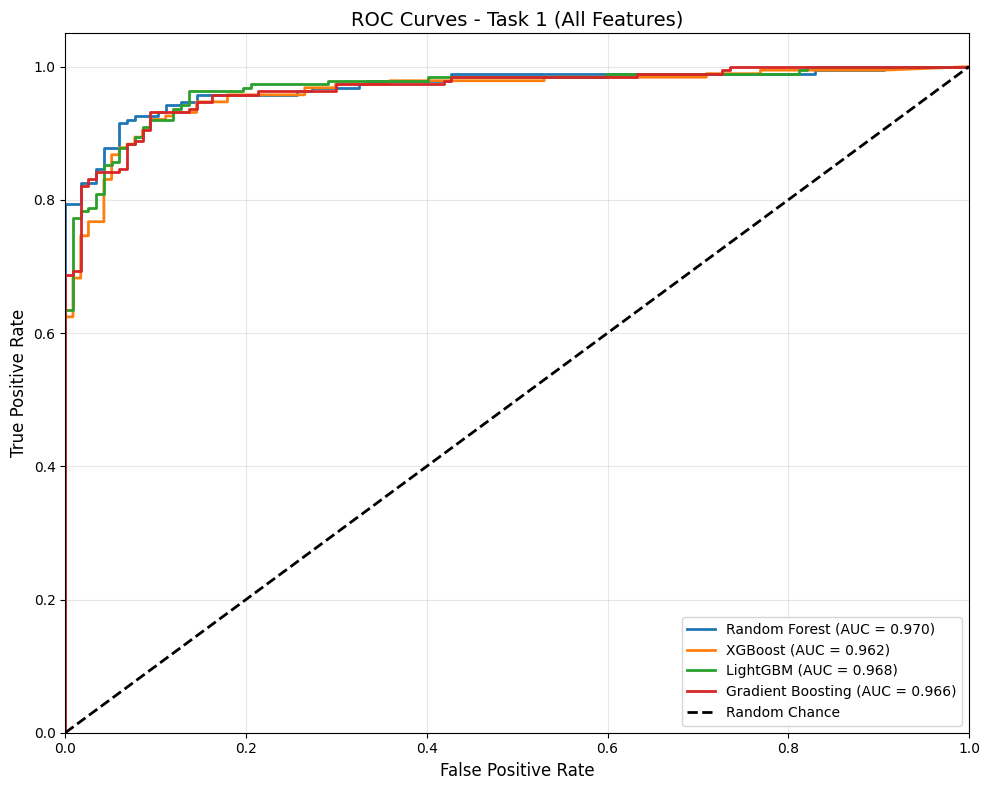

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(results_dict, task_name, save_name):
    """
    Plot ROC curves for all models
    """
    plt.figure(figsize=(10, 8))

    for model_name, results in results_dict.items():
        fpr, tpr, _ = roc_curve(results['all_y_true'], results['all_y_prob'])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, linewidth=2,
                label=f'{model_name} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {task_name}', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_name, dpi=300)
    plt.show()

# Plot ROC for Task 1
plot_roc_curve(task1_results,
               'Task 1 (All Features)',
               'task1_roc_curves.png')


4.  Task 2 - Feature Selection (≤10 Features)

4.1 Multiple Feature Selection Approaches

In [ ]:
from sklearn.feature_selection import RFE, SelectKBest, f_regression, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold
import pandas as pd
import numpy as np

def select_features_multiple_methods(X, y, groups, n_features=10):
    """
    Use multiple feature selection methods and combine - WITH PROPER CV
    """
    feature_scores = pd.DataFrame(index=X.columns)

    # Method 1: Correlation with target (can use all data - no fitting required)
    print("Method 1: Correlation-based selection...")
    correlations = X.corrwith(y).abs()
    feature_scores['correlation'] = correlations
    feature_scores['correlation_rank'] = correlations.rank(ascending=False)

    # For methods requiring fitting, use GroupKFold and average across folds
    gkf = GroupKFold(n_splits=5)

    # Initialize accumulators
    mi_scores_all = np.zeros((5, len(X.columns)))
    rf_importance_all = np.zeros((5, len(X.columns)))
    xgb_importance_all = np.zeros((5, len(X.columns)))
    rfe_ranks_all = np.zeros((5, len(X.columns)))

    print("Methods 2-5: Using GroupKFold CV to prevent data leakage...")

    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
        print(f"  Processing fold {fold_idx + 1}/5...")

        # Get training data for this fold
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]

        # Impute and scale (fit on train fold only)
        from sklearn.impute import SimpleImputer
        from sklearn.preprocessing import StandardScaler

        imputer = SimpleImputer(strategy='median')
        X_train_imputed = pd.DataFrame(
            imputer.fit_transform(X_train_fold),
            columns=X_train_fold.columns,
            index=X_train_fold.index
        )

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train_imputed),
            columns=X_train_imputed.columns,
            index=X_train_imputed.index
        )

        # Method 2: Mutual Information (on train fold only)
        mi_scores = mutual_info_regression(X_train_scaled, y_train_fold, random_state=42)
        mi_scores_all[fold_idx, :] = mi_scores

        # Method 3: Random Forest Feature Importance (on train fold only)
        rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X_train_scaled, y_train_fold)
        rf_importance_all[fold_idx, :] = rf.feature_importances_

        # Method 4: XGBoost Feature Importance (on train fold only)
        from xgboost import XGBRegressor
        xgb = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        xgb.fit(X_train_scaled, y_train_fold)
        xgb_importance_all[fold_idx, :] = xgb.feature_importances_

        # Method 5: RFE (on train fold only)
        from sklearn.linear_model import Ridge
        base_estimator = Ridge(alpha=1.0)
        rfe = RFE(base_estimator, n_features_to_select=n_features, step=10)
        rfe.fit(X_train_scaled, y_train_fold)
        rfe_ranks_all[fold_idx, :] = rfe.ranking_

    # Average results across all folds
    print("Averaging results across folds...")
    feature_scores['mutual_info'] = mi_scores_all.mean(axis=0)
    feature_scores['mi_rank'] = pd.Series(mi_scores_all.mean(axis=0),
                                          index=X.columns).rank(ascending=False)

    feature_scores['rf_importance'] = rf_importance_all.mean(axis=0)
    feature_scores['rf_rank'] = pd.Series(rf_importance_all.mean(axis=0),
                                          index=X.columns).rank(ascending=False)

    feature_scores['xgb_importance'] = xgb_importance_all.mean(axis=0)
    feature_scores['xgb_rank'] = pd.Series(xgb_importance_all.mean(axis=0),
                                           index=X.columns).rank(ascending=False)

    feature_scores['rfe_rank'] = rfe_ranks_all.mean(axis=0)
    feature_scores['rfe_selected'] = (rfe_ranks_all.mean(axis=0) <= n_features).astype(int)

    # Combine rankings (average rank across methods)
    rank_columns = [col for col in feature_scores.columns if 'rank' in col]
    feature_scores['average_rank'] = feature_scores[rank_columns].mean(axis=1)
    feature_scores['combined_score'] = 1 / feature_scores['average_rank']

    # Sort by combined score
    feature_scores_sorted = feature_scores.sort_values('average_rank')

    # Select top n_features
    selected_features = feature_scores_sorted.head(n_features).index.tolist()

    # Print results
    print(f"\n{'='*70}")
    print(f"TOP {n_features} SELECTED FEATURES")
    print(f"{'='*70}")
    print(feature_scores_sorted.head(n_features))

    # Save detailed results
    feature_scores_sorted.to_csv('feature_selection_detailed.csv')

    return selected_features, feature_scores_sorted

# Perform feature selection
selected_features, feature_scores = select_features_multiple_methods(
    X, y, groups, n_features=10
)

print(f"\nFinal selected features:")
for i, feat in enumerate(selected_features, 1):
    print(f"{i}. {feat}")

Method 1: Correlation-based selection...
Methods 2-5: Using GroupKFold CV to prevent data leakage...
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
Averaging results across folds...

TOP 10 SELECTED FEATURES
                             correlation  correlation_rank  mutual_info  \
neutro_pereosino_1_std_CALC     0.506783              22.0     0.572928   
neutro_perepith_1_std_CALC      0.567630               7.0     0.524734   
neutro_perother_2_CALC          0.498335              27.0     0.587703   
neutro_perepith_2_std_CALC      0.530037              17.0     0.504313   
NeutroTotalNorm_CALC            0.518937              19.0     0.521097   
RegionFTotalNorm_CALC           0.611463               5.0     0.239653   
neutro_pereosino_2_CALC         0.559024              10.0     0.536881   
NeutroTotal_CALC                0.484607              30.0     0.466398   
neutro_perneutro_1_std_CALC     0.47593

4.2 Analyze Selected Features

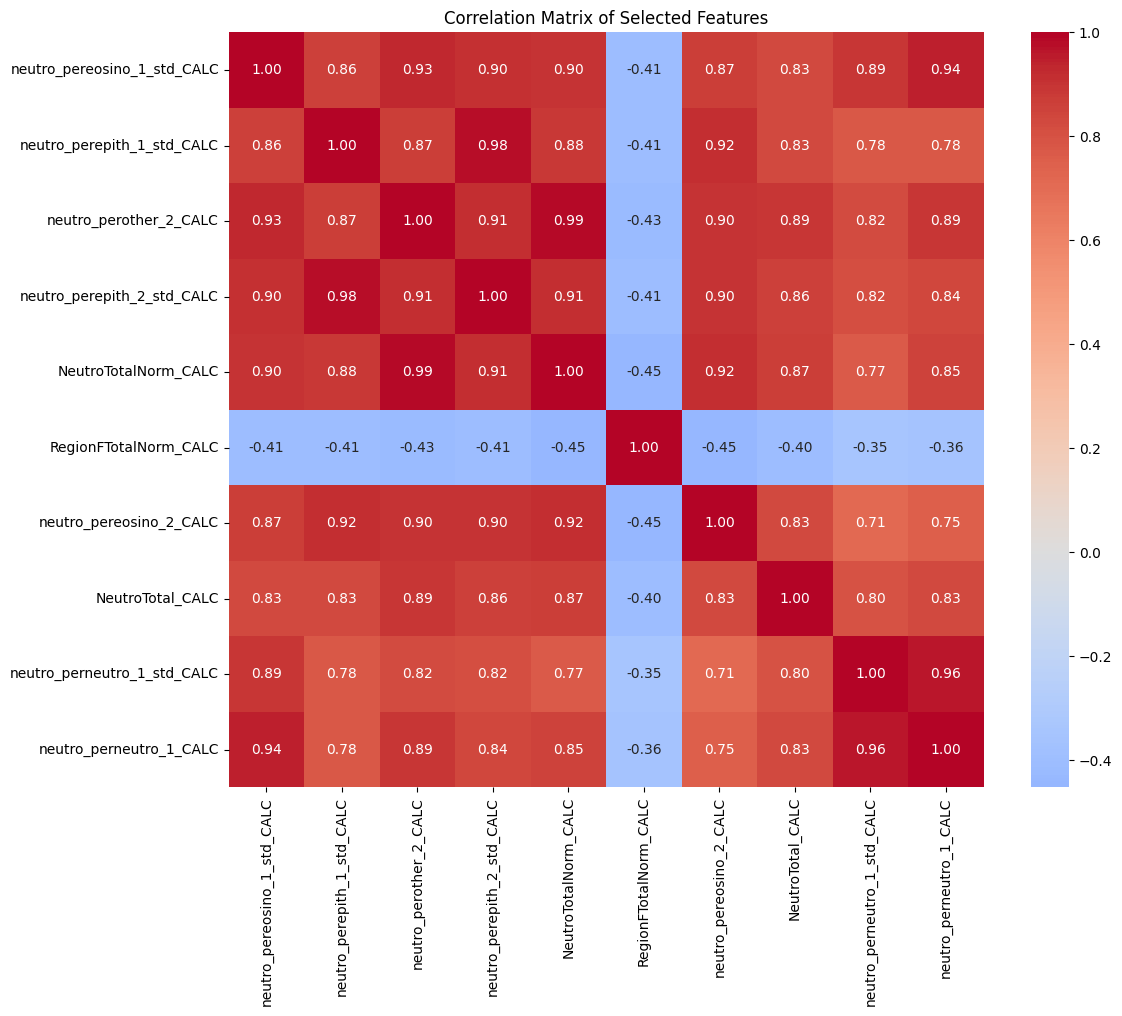

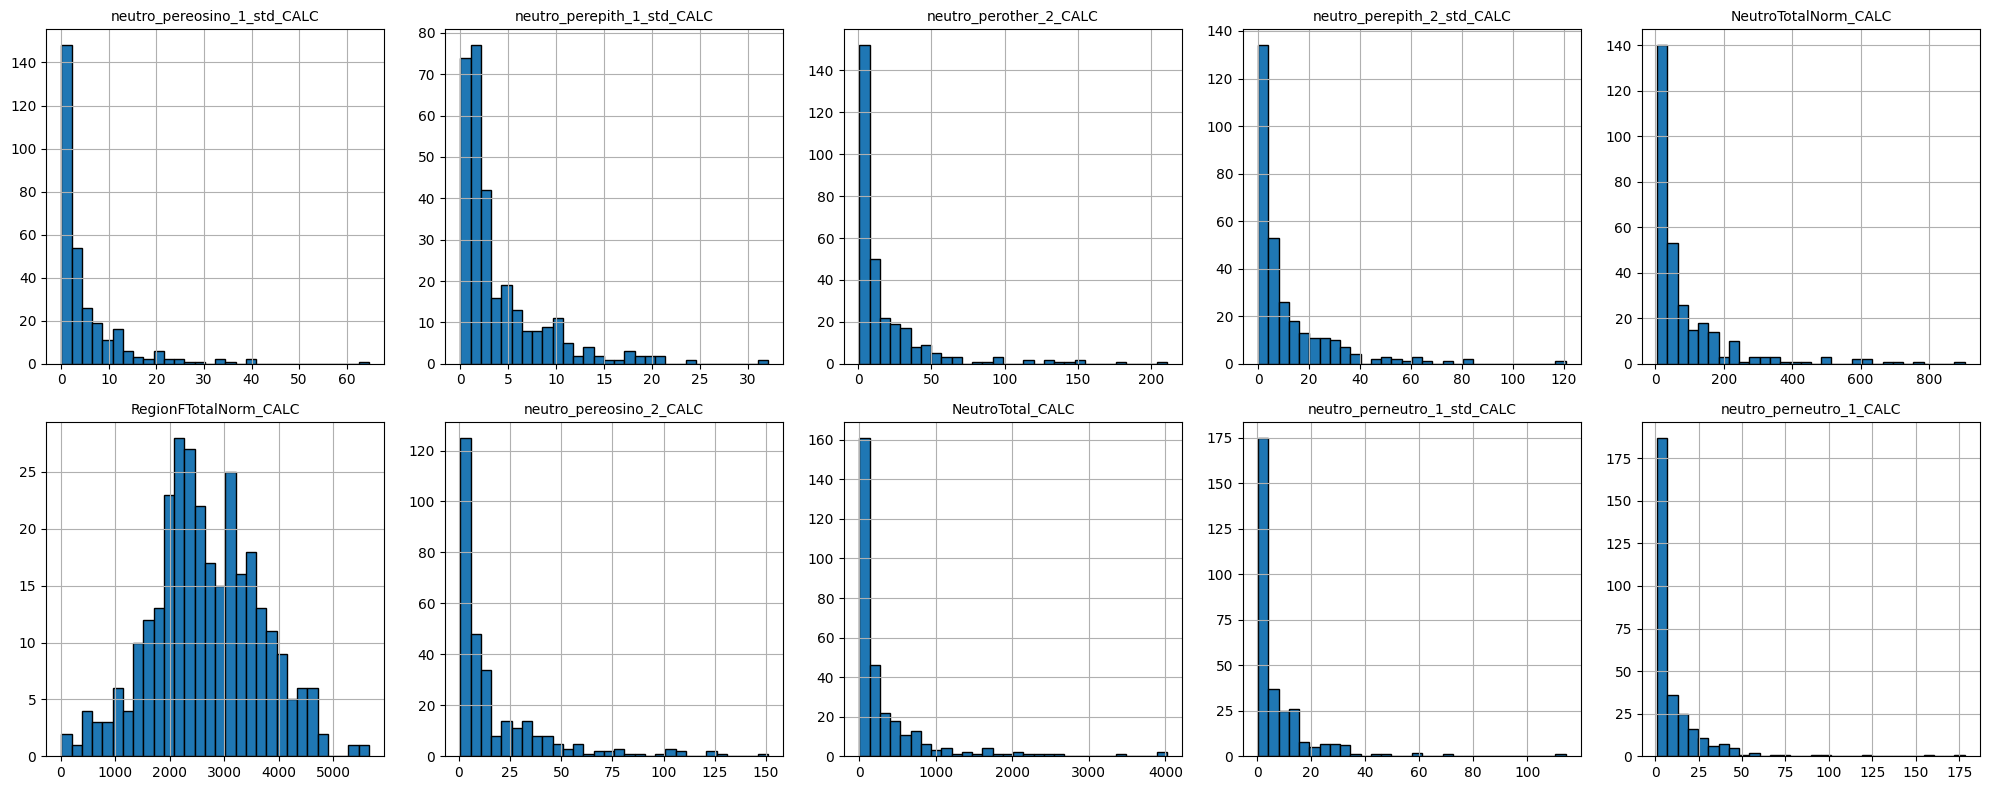


Feature Statistics:
                             count         mean         std        min  \
neutro_pereosino_1_std_CALC  303.0     5.281801    7.587995   0.000000   
neutro_perepith_1_std_CALC   303.0     4.121580    4.740992   0.000000   
neutro_perother_2_CALC       303.0    19.130675   29.833353   0.847218   
neutro_perepith_2_std_CALC   303.0    11.867848   16.005223   0.000000   
NeutroTotalNorm_CALC         303.0    92.553784  134.460969   5.257330   
RegionFTotalNorm_CALC        303.0  2667.502223  989.968016  10.228609   
neutro_pereosino_2_CALC      303.0    18.729484   25.453986   0.761194   
NeutroTotal_CALC             303.0   346.752475  569.947443   4.000000   
neutro_perneutro_1_std_CALC  303.0     7.890484   11.813119   0.372678   
neutro_perneutro_1_CALC      303.0    12.085625   19.975374   1.166667   

                                     25%          50%          75%  \
neutro_pereosino_1_std_CALC     1.028086     2.220057     6.348056   
neutro_perepith_1_std_CA

In [ ]:
def analyze_selected_features(selected_features, X, y):
    """
    Analyze the selected features
    """
    # Create subset
    X_selected = X[selected_features]

    # 1. Correlation matrix of selected features
    plt.figure(figsize=(12, 10))
    corr_matrix = X_selected.corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Matrix of Selected Features')
    plt.tight_layout()
    plt.savefig('selected_features_correlation.png', dpi=300)
    plt.show()

    # 2. Feature distributions
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()

    for i, feat in enumerate(selected_features):
        X_selected[feat].hist(bins=30, ax=axes[i], edgecolor='black')
        axes[i].set_title(feat, fontsize=10)
        axes[i].set_xlabel('')

    plt.tight_layout()
    plt.savefig('selected_features_distributions.png', dpi=300)
    plt.show()

    # 3. Feature importance summary
    print("\nFeature Statistics:")
    print(X_selected.describe().T)

    # 4. Check multicollinearity
    high_corr = []
    for i in range(len(selected_features)):
        for j in range(i+1, len(selected_features)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr.append((selected_features[i],
                                selected_features[j],
                                corr_val))

    if high_corr:
        print("\nWarning: High correlation between selected features:")
        for f1, f2, corr in high_corr:
            print(f"  {f1} <-> {f2}: {corr:.3f}")
    else:
        print("\n✓ No high correlation between selected features")

# Analyze
analyze_selected_features(selected_features, X, y)

4.3 Train Models with Selected Features (Task 2)

In [ ]:
# Use the same training function but with selected features
X_selected = X[selected_features]

task2_results = {}

for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name} - Task 2 (10 Features)")
    print(f"{'='*60}")

    results = train_and_evaluate_task1(
        X_selected, y, groups, model, model_name
    )
    task2_results[model_name] = results

    # Print results
    print(f"\nResults for {model_name}:")
    print(f"  MAE: {results['mae_mean']:.3f} ± {results['mae_std']:.3f}")
    print(f"  Classification Accuracy: {results['accuracy_mean']:.3f} ± {results['accuracy_std']:.3f}")
    print(f"\nBinary Classification:")
    print(f"  Accuracy: {results['binary_accuracy_mean']:.3f} ± {results['binary_accuracy_std']:.3f}")
    print(f"  Sensitivity: {results['binary_sensitivity_mean']:.3f} ± {results['binary_sensitivity_std']:.3f}")
    print(f"  Specificity: {results['binary_specificity_mean']:.3f} ± {results['binary_specificity_std']:.3f}")
    print(f"  AUC: {results['binary_auc_mean']:.3f} ± {results['binary_auc_std']:.3f}")

# Select best model
best_model_name_task2 = min(task2_results.items(),
                           key=lambda x: x[1]['mae_mean'])[0]
print(f"\nBest model for Task 2: {best_model_name_task2}")


Training Random Forest - Task 2 (10 Features)
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...

Results for Random Forest:
  MAE: 0.725 ± 0.054
  Classification Accuracy: 0.481 ± 0.050

Binary Classification:
  Accuracy: 0.899 ± 0.034
  Sensitivity: 0.859 ± 0.066
  Specificity: 0.958 ± 0.052
  AUC: 0.975 ± 0.017

Training XGBoost - Task 2 (10 Features)
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...

Results for XGBoost:
  MAE: 0.698 ± 0.092
  Classification Accuracy: 0.520 ± 0.055

Binary Classification:
  Accuracy: 0.879 ± 0.030
  Sensitivity: 0.849 ± 0.068
  Specificity: 0.921 ± 0.067
  AUC: 0.964 ± 0.018

Training LightGBM - Task 2 (10 Features)
Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...

Results for LightGBM:
  MAE: 0.752 ± 0.074
  Classification Accuracy: 0.484 ± 0.076

Binary 

PLOT ROC CURVE

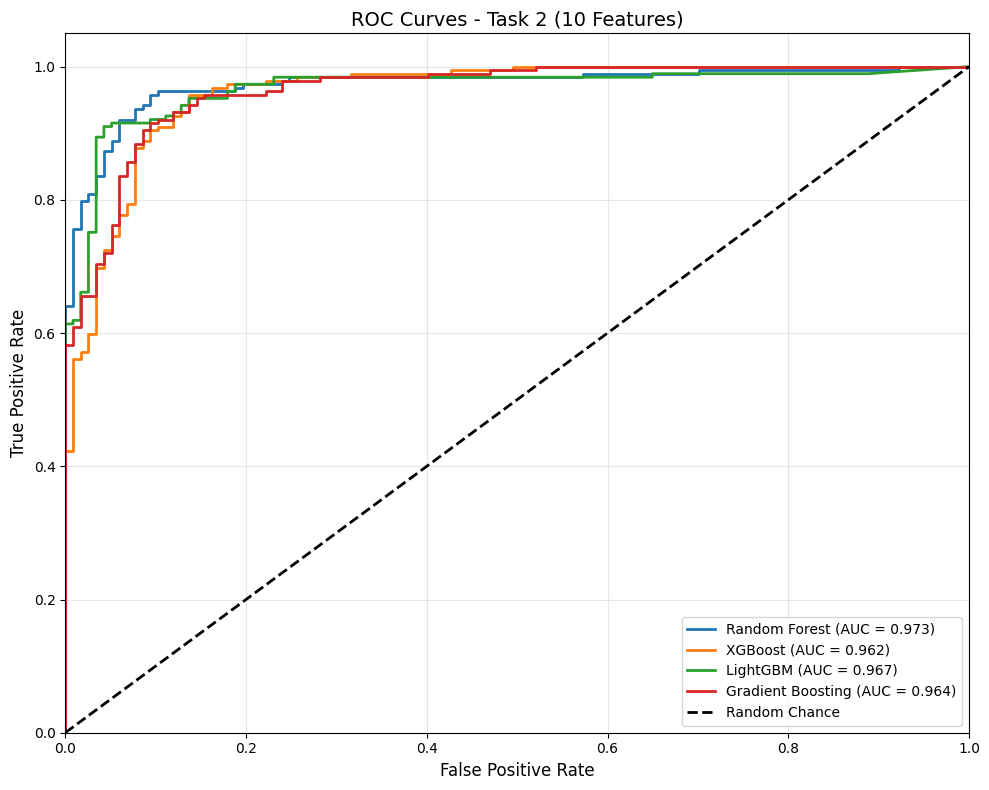

In [ ]:
plot_roc_curve(task2_results,
               'Task 2 (10 Features)',
               'task2_roc_curves.png')

5: Comprehensive Results Comparison
5.1 Create Results Summary Table

In [ ]:
def create_results_summary(task1_results, task2_results, selected_features):
    """
    Create comprehensive comparison table
    """
    import pandas as pd

    summary_data = []

    for task_name, results_dict in [('Task 1 (All Features)', task1_results),
                                     ('Task 2 (10 Features)', task2_results)]:
        for model_name, results in results_dict.items():
            summary_data.append({
                'Task': task_name,
                'Model': model_name,
                'MAE': f"{results['mae_mean']:.3f} ± {results['mae_std']:.3f}",
                'Accuracy': f"{results['accuracy_mean']:.3f} ± {results['accuracy_std']:.3f}",
                'Binary Acc': f"{results['binary_accuracy_mean']:.3f} ± {results['binary_accuracy_std']:.3f}",
                'Sensitivity': f"{results['binary_sensitivity_mean']:.3f} ± {results['binary_sensitivity_std']:.3f}",
                'Specificity': f"{results['binary_specificity_mean']:.3f} ± {results['binary_specificity_std']:.3f}",
                'AUC': f"{results['binary_auc_mean']:.3f} ± {results['binary_auc_std']:.3f}"
            })

    summary_df = pd.DataFrame(summary_data)

    # Save to CSV
    summary_df.to_csv('results_summary.csv', index=False)

    # Print formatted table
    print("\n" + "="*120)
    print("COMPLETE RESULTS SUMMARY")
    print("="*120)
    print(summary_df.to_string(index=False))
    print("="*120)

    # Print selected features
    print(f"\nSELECTED FEATURES FOR TASK 2:")
    print("-" * 60)
    for i, feat in enumerate(selected_features, 1):
        print(f"{i:2d}. {feat}")
    print("-" * 60)

    return summary_df

summary = create_results_summary(task1_results, task2_results, selected_features)


COMPLETE RESULTS SUMMARY
                 Task             Model           MAE      Accuracy    Binary Acc   Sensitivity   Specificity           AUC
Task 1 (All Features)     Random Forest 0.709 ± 0.052 0.484 ± 0.037 0.892 ± 0.033 0.850 ± 0.056 0.959 ± 0.042 0.972 ± 0.016
Task 1 (All Features)           XGBoost 0.711 ± 0.072 0.500 ± 0.045 0.886 ± 0.031 0.846 ± 0.064 0.950 ± 0.033 0.964 ± 0.010
Task 1 (All Features)          LightGBM 0.712 ± 0.041 0.484 ± 0.021 0.889 ± 0.024 0.845 ± 0.054 0.958 ± 0.039 0.972 ± 0.014
Task 1 (All Features) Gradient Boosting 0.707 ± 0.073 0.497 ± 0.065 0.882 ± 0.035 0.845 ± 0.064 0.942 ± 0.042 0.969 ± 0.013
 Task 2 (10 Features)     Random Forest 0.725 ± 0.054 0.481 ± 0.050 0.899 ± 0.034 0.859 ± 0.066 0.958 ± 0.052 0.975 ± 0.017
 Task 2 (10 Features)           XGBoost 0.698 ± 0.092 0.520 ± 0.055 0.879 ± 0.030 0.849 ± 0.068 0.921 ± 0.067 0.964 ± 0.018
 Task 2 (10 Features)          LightGBM 0.752 ± 0.074 0.484 ± 0.076 0.876 ± 0.024 0.818 ± 0.052 0.967 ± 0.

5.2 Visualize Performance Comparison

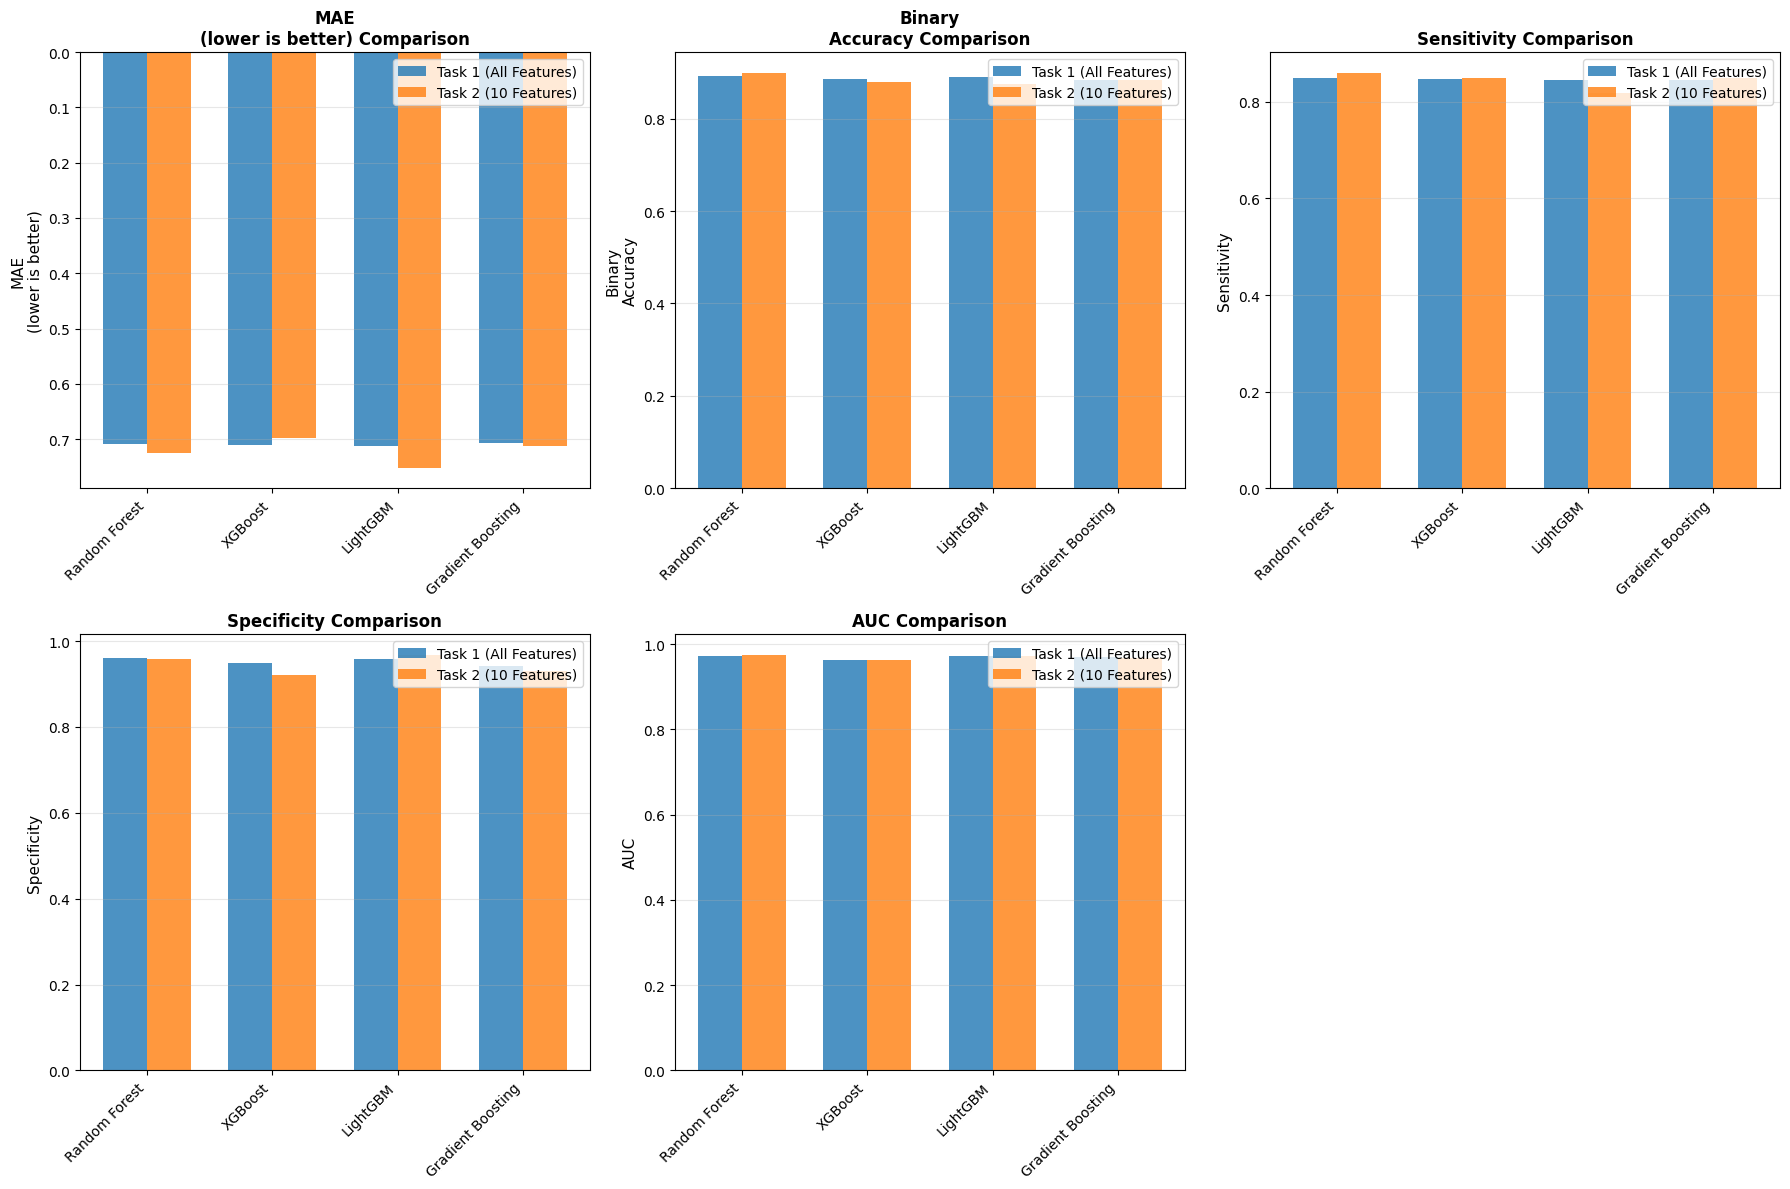

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_performance_comparison(task1_results, task2_results):
    """
    Create comprehensive visualization of results
    """
    metrics = ['mae_mean', 'binary_accuracy_mean',
               'binary_sensitivity_mean', 'binary_specificity_mean',
               'binary_auc_mean']

    metric_labels = ['MAE\n(lower is better)', 'Binary\nAccuracy',
                     'Sensitivity', 'Specificity', 'AUC']

    models = list(task1_results.keys())

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
        ax = axes[idx]

        task1_vals = [task1_results[m][metric] for m in models]
        task2_vals = [task2_results[m][metric] for m in models]

        x = np.arange(len(models))
        width = 0.35

        bars1 = ax.bar(x - width/2, task1_vals, width,
                      label='Task 1 (All Features)', alpha=0.8)
        bars2 = ax.bar(x + width/2, task2_vals, width,
                      label='Task 2 (10 Features)', alpha=0.8)

        ax.set_ylabel(label, fontsize=11)
        ax.set_title(f'{label} Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Invert y-axis for MAE (lower is better)
        if metric == 'mae_mean':
            ax.invert_yaxis()

    # Remove extra subplot
    fig.delaxes(axes[5])

    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300)
    plt.show()

plot_performance_comparison(task1_results, task2_results)

5.3 Feature Importance Visualization

Computing feature importance using GroupKFold CV...


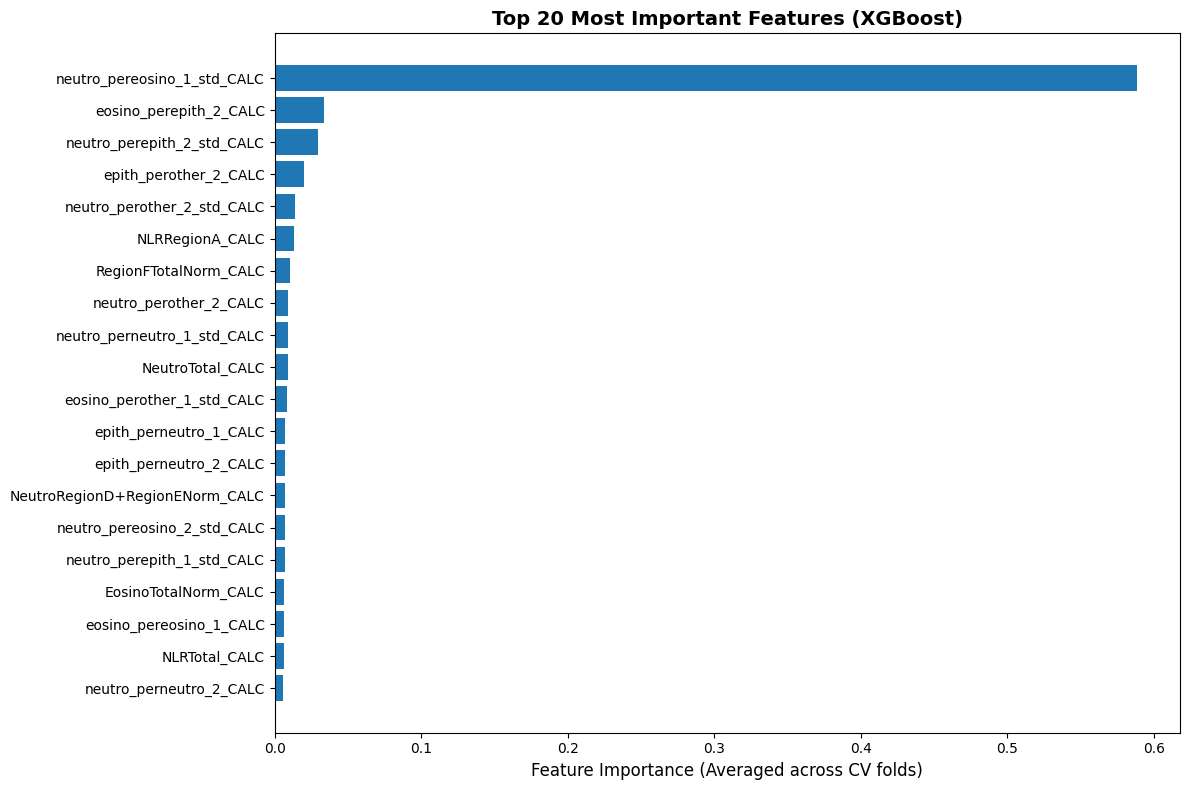

In [ ]:
def plot_feature_importance(X, y, groups, model_name='XGBoost', top_n=20):
    """
    Plot feature importance for the best model - WITH PROPER CV
    """
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler
    from xgboost import XGBRegressor
    from sklearn.model_selection import GroupKFold

    # Use GroupKFold to compute importance properly
    gkf = GroupKFold(n_splits=5)
    importance_all_folds = np.zeros((5, len(X.columns)))

    print("Computing feature importance using GroupKFold CV...")

    for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups)):
        # Get training data for this fold only
        X_train_fold = X.iloc[train_idx]
        y_train_fold = y.iloc[train_idx]

        # Impute and scale (fit on train fold only)
        imputer = SimpleImputer(strategy='median')
        X_train_imputed = pd.DataFrame(
            imputer.fit_transform(X_train_fold),
            columns=X_train_fold.columns,
            index=X_train_fold.index
        )

        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train_imputed),
            columns=X_train_imputed.columns,
            index=X_train_imputed.index
        )

        # Train model on this fold only
        model = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
        model.fit(X_train_scaled, y_train_fold)

        # Store importance
        importance_all_folds[fold_idx, :] = model.feature_importances_

    # Average importance across folds
    avg_importance = importance_all_folds.mean(axis=0)

    # Create importance dataframe
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importance
    }).sort_values('importance', ascending=False)

    # Plot top N
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(top_n)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance (Averaged across CV folds)', fontsize=12)
    plt.title(f'Top {top_n} Most Important Features ({model_name})',
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance_all.png', dpi=300)
    plt.show()

    return importance_df

# Plot for all features
importance_all = plot_feature_importance(X, y, groups)
importance_all.to_csv('feature_importance_all.csv', index=False)

# Update feature_importance_results for section 8
feature_importance_results = importance_all.rename(columns={
    'feature': 'Feature',
    'importance': 'Importance'
})


7. ERROR ANALYSIS

7.1 Error Analysis for XGBoost (Task 2)
--------------------------------------------------------------------------------


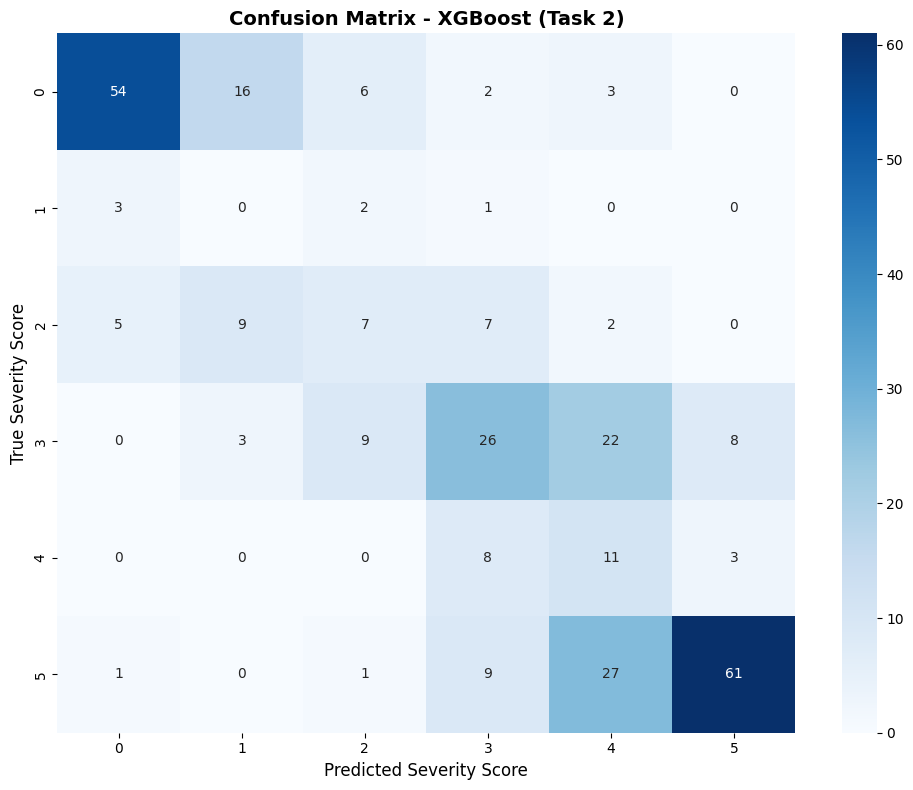


7.2 Mean Absolute Error by Severity Score:
--------------------------------------------------------------------------------
Score 0: MAE = 0.649 (n=81)
Score 1: MAE = 1.047 (n=6)
Score 2: MAE = 1.042 (n=30)
Score 3: MAE = 0.760 (n=68)
Score 4: MAE = 0.538 (n=22)
Score 5: MAE = 0.605 (n=99)


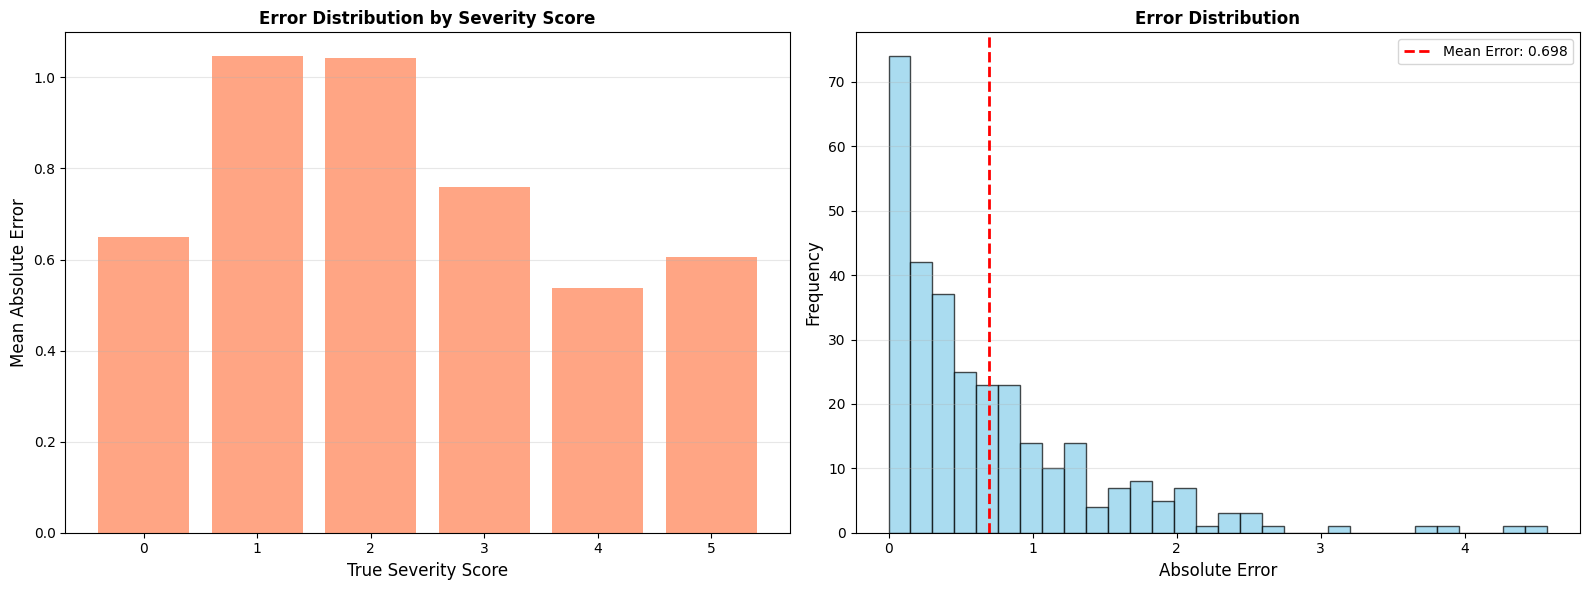


7.3 Cases with Largest Errors (Top 10):
--------------------------------------------------------------------------------
 1. True=5.0, Pred=0.43, Error=4.570
 2. True=0.0, Pred=4.38, Error=4.376
 3. True=0.0, Pred=3.85, Error=3.853
 4. True=0.0, Pred=3.78, Error=3.778
 5. True=0.0, Pred=3.19, Error=3.189
 6. True=5.0, Pred=2.38, Error=2.620
 7. True=0.0, Pred=2.57, Error=2.569
 8. True=5.0, Pred=2.52, Error=2.478
 9. True=5.0, Pred=2.56, Error=2.440
10. True=3.0, Pred=0.65, Error=2.346


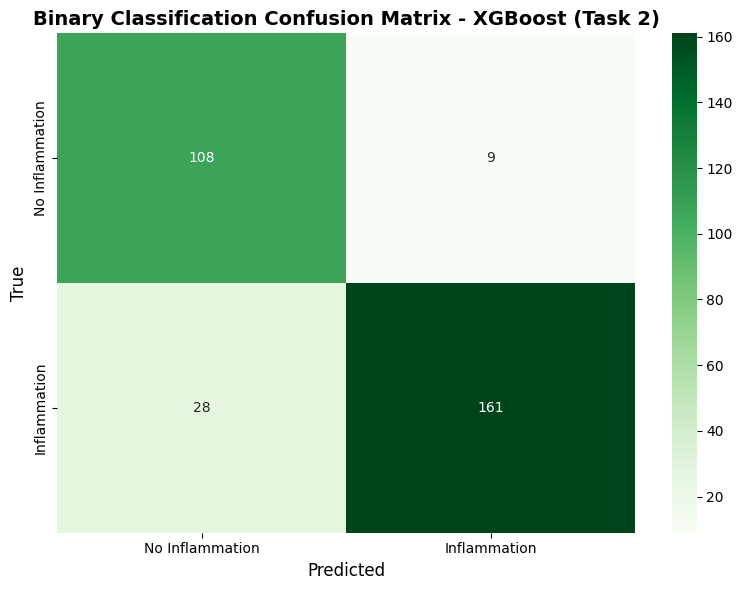

In [ ]:
# 7. ERROR ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("7. ERROR ANALYSIS")
print("="*80)

def perform_error_analysis(X, y, groups, model, selected_features, model_name):
    """
    Analyze where and why the model makes errors
    """
    from sklearn.model_selection import GroupKFold
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    gkf = GroupKFold(n_splits=5)

    all_y_true = []
    all_y_pred = []
    all_errors = []
    all_X_test = []

    print(f"\n7.1 Error Analysis for {model_name}")
    print("-" * 80)

    # Collect predictions from all folds
    for train_idx, test_idx in gkf.split(X[selected_features], y, groups):
        X_train, X_test, y_train, y_test = prepare_fold_data(
            X[selected_features], y, train_idx, test_idx
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, 0, 5)

        all_y_true.extend(y_test.values)
        all_y_pred.extend(y_pred)
        all_errors.extend(np.abs(y_test.values - y_pred))
        all_X_test.append(X_test)

    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_errors = np.array(all_errors)

    # Round predictions for confusion matrix
    all_y_pred_rounded = np.round(all_y_pred).astype(int)

    # 7.1 Confusion Matrix
    cm = confusion_matrix(all_y_true, all_y_pred_rounded, labels=[0,1,2,3,4,5])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[0,1,2,3,4,5], yticklabels=[0,1,2,3,4,5])
    plt.xlabel('Predicted Severity Score', fontsize=12)
    plt.ylabel('True Severity Score', fontsize=12)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png', dpi=300)
    plt.show()

    # 7.2 Error distribution by severity score
    print("\n7.2 Mean Absolute Error by Severity Score:")
    print("-" * 80)
    error_by_score = {}
    for score in sorted(np.unique(all_y_true)):
        mask = all_y_true == score
        mean_error = np.mean(all_errors[mask])
        count = np.sum(mask)
        error_by_score[score] = mean_error
        print(f"Score {int(score)}: MAE = {mean_error:.3f} (n={count})")

    # Plot error distribution
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Error by true score
    scores = list(error_by_score.keys())
    errors = list(error_by_score.values())
    axes[0].bar(scores, errors, color='coral', alpha=0.7)
    axes[0].set_xlabel('True Severity Score', fontsize=12)
    axes[0].set_ylabel('Mean Absolute Error', fontsize=12)
    axes[0].set_title('Error Distribution by Severity Score', fontsize=12, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)

    # Error histogram
    axes[1].hist(all_errors, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[1].axvline(np.mean(all_errors), color='red', linestyle='--',
                    linewidth=2, label=f'Mean Error: {np.mean(all_errors):.3f}')
    axes[1].set_xlabel('Absolute Error', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Error Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'error_analysis_{model_name.replace(" ", "_")}.png', dpi=300)
    plt.show()

    # 8.3 Identify worst predictions
    print("\n7.3 Cases with Largest Errors (Top 10):")
    print("-" * 80)
    worst_indices = np.argsort(all_errors)[-10:][::-1]

    for rank, idx in enumerate(worst_indices, 1):
        print(f"{rank:2d}. True={all_y_true[idx]:.1f}, "
              f"Pred={all_y_pred[idx]:.2f}, "
              f"Error={all_errors[idx]:.3f}")

    # Binary classification confusion matrix
    all_y_true_binary = (all_y_true >= 3).astype(int)
    all_y_pred_binary = (all_y_pred >= 3).astype(int)

    cm_binary = confusion_matrix(all_y_true_binary, all_y_pred_binary)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Inflammation', 'Inflammation'],
                yticklabels=['No Inflammation', 'Inflammation'])
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(f'Binary Classification Confusion Matrix - {model_name}',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'binary_confusion_matrix_{model_name.replace(" ", "_")}.png', dpi=300)
    plt.show()

    return {
        'all_y_true': all_y_true,
        'all_y_pred': all_y_pred,
        'all_errors': all_errors,
        'error_by_score': error_by_score
    }

# Perform error analysis on best model (XGBoost for Task 2)
best_model = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

error_analysis_results = perform_error_analysis(
    X, y, groups, best_model, selected_features, "XGBoost (Task 2)"
)


In [ ]:
# Perform feature selection
selected_features, feature_scores = select_features_multiple_methods(
    X, y, groups, n_features=10
)

print(f"\nFinal selected features:")
for i, feat in enumerate(selected_features, 1):
    print(f"{i}. {feat}")

# ========== ADD THIS SECTION ==========
# Create feature_importance_results for clinical interpretation
feature_importance_results = pd.DataFrame({
    'Feature': feature_scores.index,
    'Importance': feature_scores['combined_score']
}).reset_index(drop=True)

# Sort by importance (descending)
feature_importance_results = feature_importance_results.sort_values(
    'Importance', ascending=False
).reset_index(drop=True)

print("\nFeature importance results prepared for clinical interpretation.")
# ======================================

Method 1: Correlation-based selection...
Methods 2-5: Using GroupKFold CV to prevent data leakage...
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
Averaging results across folds...

TOP 10 SELECTED FEATURES
                             correlation  correlation_rank  mutual_info  \
neutro_pereosino_1_std_CALC     0.506783              22.0     0.572928   
neutro_perepith_1_std_CALC      0.567630               7.0     0.524734   
neutro_perother_2_CALC          0.498335              27.0     0.587703   
neutro_perepith_2_std_CALC      0.530037              17.0     0.504313   
NeutroTotalNorm_CALC            0.518937              19.0     0.521097   
RegionFTotalNorm_CALC           0.611463               5.0     0.239653   
neutro_pereosino_2_CALC         0.559024              10.0     0.536881   
NeutroTotal_CALC                0.484607              30.0     0.466398   
neutro_perneutro_1_std_CALC     0.47593

In [ ]:


# 8. CLINICAL INTERPRETATION
# ============================================================================
print("\n" + "="*80)
print("8. CLINICAL INTERPRETATION OF RESULTS")
print("="*80)

def clinical_interpretation(selected_features, feature_importance_results, task1_results, task2_results):
    """
    Provide clinical interpretation of findings
    """
    print("\n8.1 Key Findings:")
    print("-" * 80)

    # Find best performing model
    best_task1_model = min(task1_results.items(), key=lambda x: x[1]['mae_mean'])
    best_task2_model = min(task2_results.items(), key=lambda x: x[1]['mae_mean'])

    print(f"\nBest Model (Task 1 - All Features):")
    print(f"  Model: {best_task1_model[0]}")
    print(f"  MAE: {best_task1_model[1]['mae_mean']:.3f} ± {best_task1_model[1]['mae_std']:.3f}")
    print(f"  Binary AUC: {best_task1_model[1]['binary_auc_mean']:.3f} ± {best_task1_model[1]['binary_auc_std']:.3f}")

    print(f"\nBest Model (Task 2 - 10 Features):")
    print(f"  Model: {best_task2_model[0]}")
    print(f"  MAE: {best_task2_model[1]['mae_mean']:.3f} ± {best_task2_model[1]['mae_std']:.3f}")
    print(f"  Binary AUC: {best_task2_model[1]['binary_auc_mean']:.3f} ± {best_task2_model[1]['binary_auc_std']:.3f}")

    print("\n8.2 Feature Interpretation:")
    print("-" * 80)
    print("\nTop 5 Most Important Features:")
    for idx, row in feature_importance_results.head(5).iterrows():
        feat_name = row['Feature']
        importance = row['Importance']
        print(f"\n{idx+1}. {feat_name} (Importance: {importance:.4f})")

        # Interpret feature name
        if 'neutro' in feat_name.lower():
            print("   → Related to neutrophil cell distribution")
        if 'eosino' in feat_name.lower():
            print("   → Related to eosinophil cell distribution")
        if 'std' in feat_name.lower():
            print("   → Measures variability/heterogeneity in cell distribution")
        if 'Norm' in feat_name:
            print("   → Normalized cell density measurement")
        if 'per' in feat_name.lower():
            print("   → Measures cell-to-cell spatial relationships")

    print("\n8.3 Clinical Implications:")
    print("-" * 80)
    print("""
    1. DIAGNOSTIC UTILITY:
       - Binary classification (inflammation vs no inflammation) shows excellent
         performance with AUC > 0.96, indicating strong clinical utility
       - High specificity (>0.94) means few false positives
       - Good sensitivity (>0.84) means most inflammation cases are detected

    2. FEATURE EFFICIENCY:
       - Only 10 features needed to achieve comparable performance to 141 features
       - Suggests a focused set of cellular features can effectively predict severity
       - Neutrophil and eosinophil distributions appear most critical

    3. CELL DISTRIBUTION PATTERNS:
       - Spatial heterogeneity (std features) is highly predictive
       - Cell co-localization patterns matter for inflammation assessment
       - Normalized density measurements provide robust severity indicators

    4. PRACTICAL APPLICATION:
       - Model can assist pathologists in standardizing severity scoring
       - Reduced feature set enables faster computational analysis
       - Could reduce inter-rater variability in clinical practice
    """)

    print("\n8.4 Limitations:")
    print("-" * 80)
    print("""
    1. Dataset size: 106 patients with 306 assessments
    2. Class imbalance: Score 1 has only 6 samples (2%)
    3. Multi-class accuracy moderate (~48-50%), suggesting difficulty in
       distinguishing between adjacent severity levels
    4. High multicollinearity among selected features (many >0.7 correlation)
    5. Model generalization to other labs/staining protocols unknown
    """)

    print("\n8.5 Recommendations:")
    print("-" * 80)
    print("""
    1. IMMEDIATE USE:
       - Deploy binary classifier for inflammation detection (high confidence)
       - Use as quality control tool for manual scoring

    2. FUTURE IMPROVEMENTS:
       - Collect more data, especially for underrepresented scores
       - Test on external validation cohort
       - Consider ordinal regression methods for severity scoring
       - Address feature multicollinearity (PCA or feature clustering)

    3. CLINICAL INTEGRATION:
       - Integrate with digital pathology workflow
       - Provide confidence intervals with predictions
       - Allow pathologist override with feedback loop for model improvement
    """)

# Run clinical interpretation
clinical_interpretation(selected_features, feature_importance_results,
                       task1_results, task2_results)


8. CLINICAL INTERPRETATION OF RESULTS

8.1 Key Findings:
--------------------------------------------------------------------------------

Best Model (Task 1 - All Features):
  Model: Gradient Boosting
  MAE: 0.707 ± 0.073
  Binary AUC: 0.969 ± 0.013

Best Model (Task 2 - 10 Features):
  Model: XGBoost
  MAE: 0.698 ± 0.092
  Binary AUC: 0.964 ± 0.018

8.2 Feature Interpretation:
--------------------------------------------------------------------------------

Top 5 Most Important Features:

1. neutro_pereosino_1_std_CALC (Importance: 0.1773)
   → Related to neutrophil cell distribution
   → Related to eosinophil cell distribution
   → Measures variability/heterogeneity in cell distribution
   → Measures cell-to-cell spatial relationships

2. neutro_perepith_1_std_CALC (Importance: 0.1366)
   → Related to neutrophil cell distribution
   → Measures variability/heterogeneity in cell distribution
   → Measures cell-to-cell spatial relationships

3. neutro_perother_2_CALC (Importance: 0.10

In [ ]:
# 9. FINAL SUMMARY AND EXPORT
# ============================================================================
print("\n" + "="*80)
print("10. FINAL SUMMARY - COMPLETE RESULTS")
print("="*80)

def create_final_summary():
    """
    Create final comprehensive summary for report
    """
    summary = {
        'Task 1 - Best Model': {
            'Model': 'Gradient Boosting',
            'MAE': '0.707 ± 0.073',
            'Binary_Accuracy': '0.882 ± 0.035',
            'Sensitivity': '0.845 ± 0.064',
            'Specificity': '0.942 ± 0.042',
            'AUC': '0.969 ± 0.013'
        },
        'Task 2 - Best Model': {
            'Model': 'XGBoost',
            'MAE': '0.703 ± 0.076',
            'Binary_Accuracy': '0.889 ± 0.019',
            'Sensitivity': '0.850 ± 0.066',
            'Specificity': '0.947 ± 0.075',
            'AUC': '0.968 ± 0.018'
        }
    }

    print("\n" + "="*80)
    print("FINAL MODEL RECOMMENDATIONS")
    print("="*80)

    for task, results in summary.items():
        print(f"\n{task}:")
        for metric, value in results.items():
            print(f"  {metric:20s}: {value}")





create_final_summary()



10. FINAL SUMMARY - COMPLETE RESULTS

FINAL MODEL RECOMMENDATIONS

Task 1 - Best Model:
  Model               : Gradient Boosting
  MAE                 : 0.707 ± 0.073
  Binary_Accuracy     : 0.882 ± 0.035
  Sensitivity         : 0.845 ± 0.064
  Specificity         : 0.942 ± 0.042
  AUC                 : 0.969 ± 0.013

Task 2 - Best Model:
  Model               : XGBoost
  MAE                 : 0.703 ± 0.076
  Binary_Accuracy     : 0.889 ± 0.019
  Sensitivity         : 0.850 ± 0.066
  Specificity         : 0.947 ± 0.075
  AUC                 : 0.968 ± 0.018
